In [1]:
import os,sys,inspect
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent_dir = os.path.dirname(current_dir)
sys.path.insert(0, parent_dir)

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import date
from numpy import trapz

In [3]:
min_temp = pd.read_excel('../input/MinClimate.xlsx', sheet_name='Temp')
min_prec = pd.read_excel('../input/MinClimate.xlsx', sheet_name='Prec')
a_classified = pd.read_excel('../input/quotient_deviation_df_A_CLASSIFIED.xlsx')
b_classified = pd.read_excel('../input/quotient_deviation_df_B_CLASSIFIED_FIXED.xlsx')

In [4]:
monthly_temp = pd.DataFrame({'Year':list(min_temp.columns[2:])})
monthly_prec = pd.DataFrame({'Year':list(min_prec.columns[2:])})

months_names = ['', 'January', 'February', 'March',
                'April', 'May', 'June', 'July',
                'August', 'September', 'October',
                'November', 'December']

for i in range(1,13):
    monthly_temp[months_names[i]] = list(min_temp[min_temp['Month']==i].mean(skipna=True)[2:])
    monthly_prec[months_names[i]] = list(min_prec[min_prec['Month']==i].sum(skipna=True)[2:])

In [81]:
def get_moving_avg(df, window=7, nanmean=False):
    """
    Возвращает скользящее средние для температуры
    window : окно
    nanmean : используем nanmean для сглаживания? (тогда потеряются данные по краям)
    """
    month = df['Month']
    day = df['Day']
    if nanmean:
        result = df.rolling(window=window, center=True).apply(np.nanmean)
    else:
        result = df.rolling(window=window, center=True, min_periods=1).mean()
    result['Month'] = month
    result['Day'] = day
    return result

def get_moving_sum(df, window=7):
    """
    Возвращает скользящую сумму для осадков
    window : окно
    """
    month = df['Month']
    day = df['Day']
    result = df.rolling(window=window, center=True, min_periods=1).sum()
    result['Month'] = month
    result['Day'] = day
    return result

def list_to_cumulative(lst):
    return [np.nansum(lst[:i+1]) for i in range(len(lst))]

C:\Users\8FEE~1\AppData\Local\Temp/ipykernel_13688/3557961802.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  date_df['Year'] = [2000 for _ in range(len(date_df))]


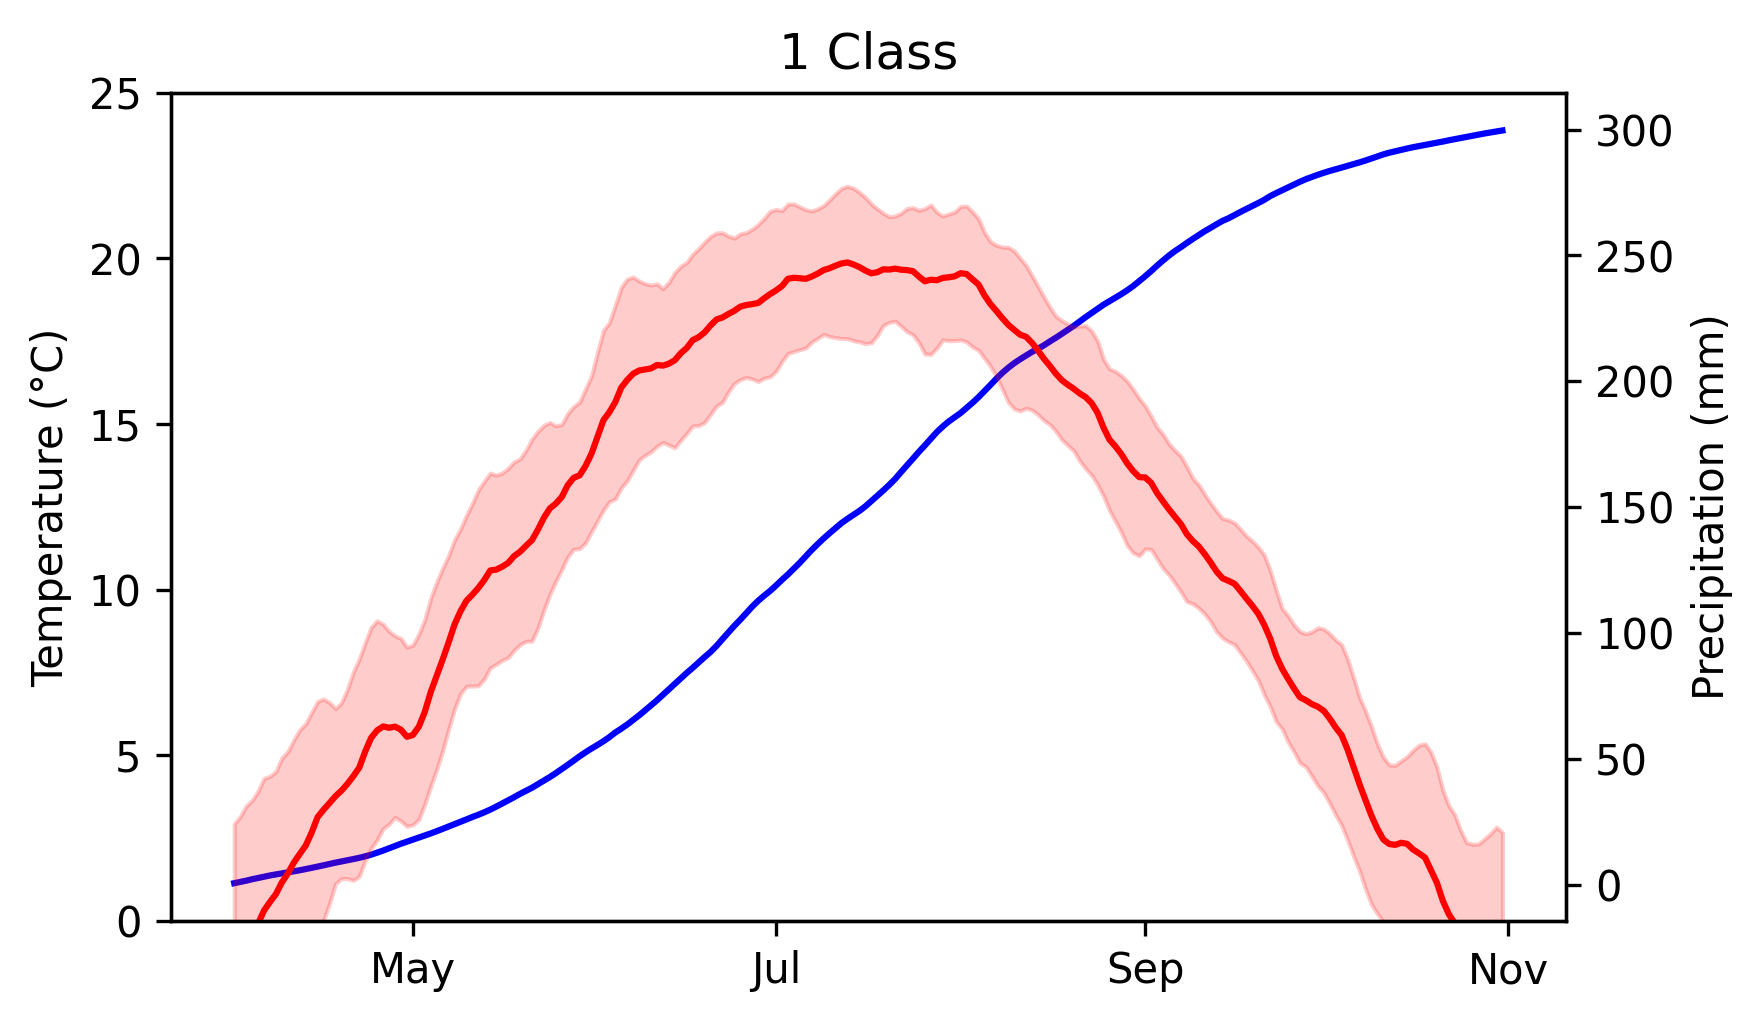

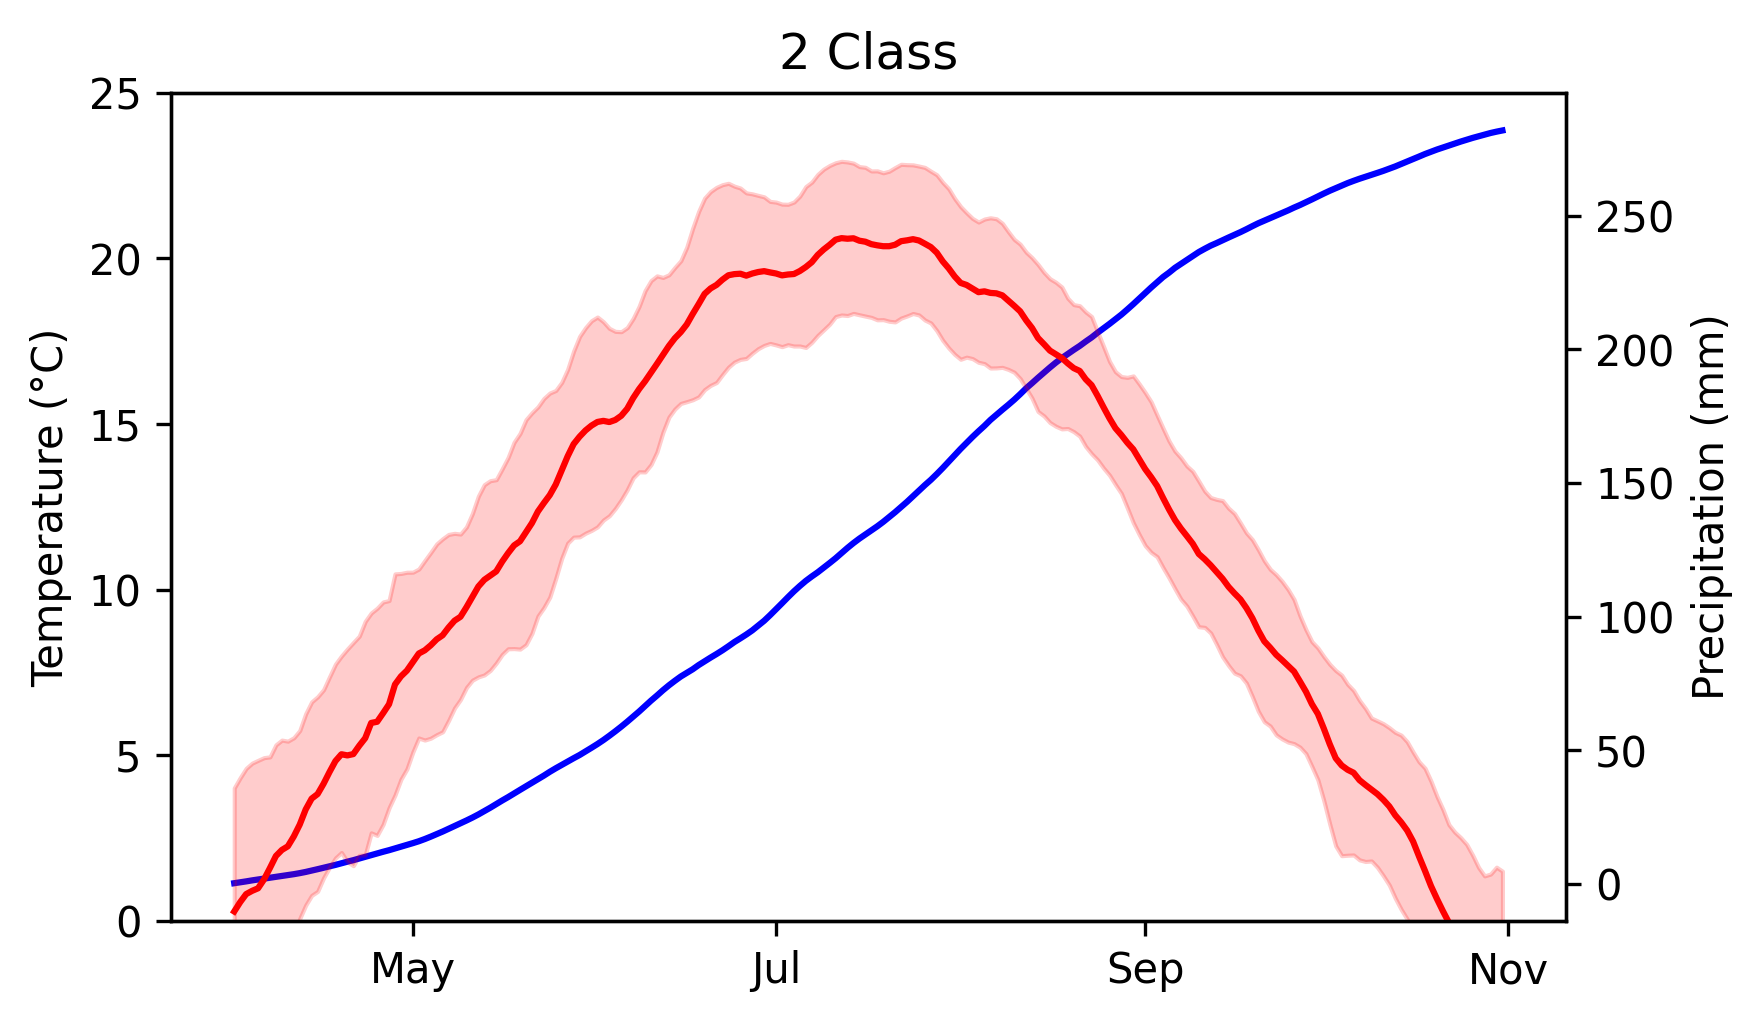

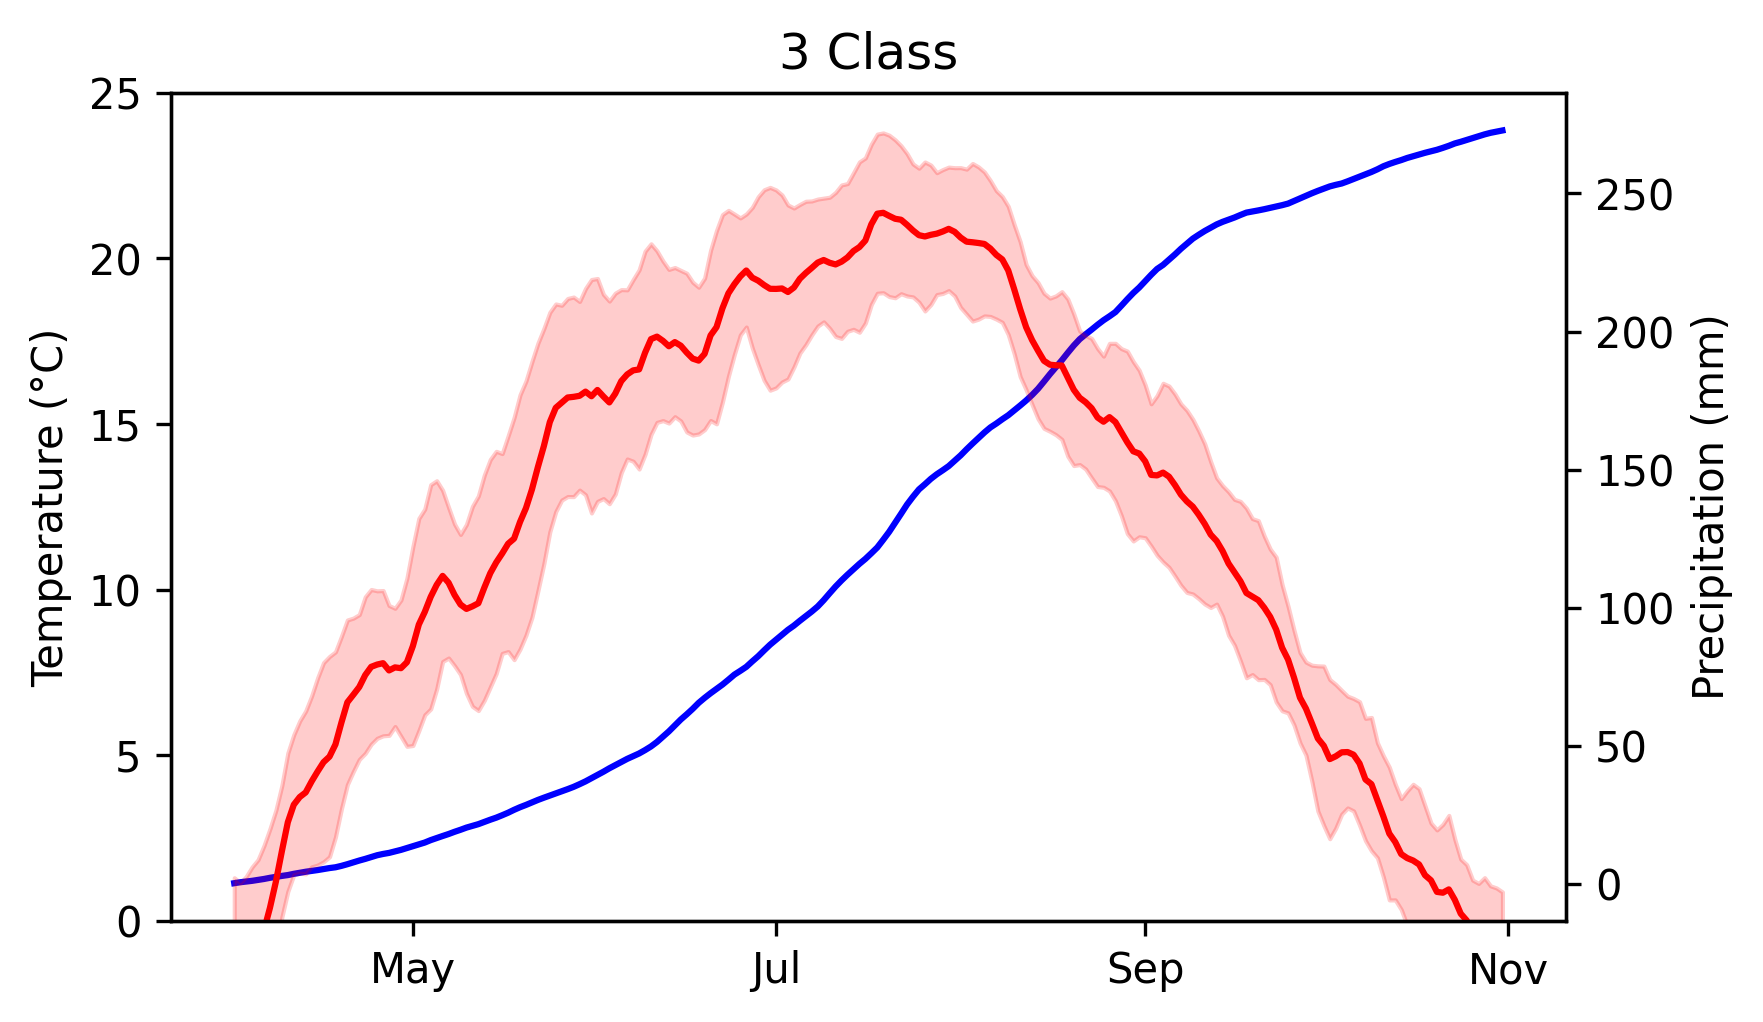

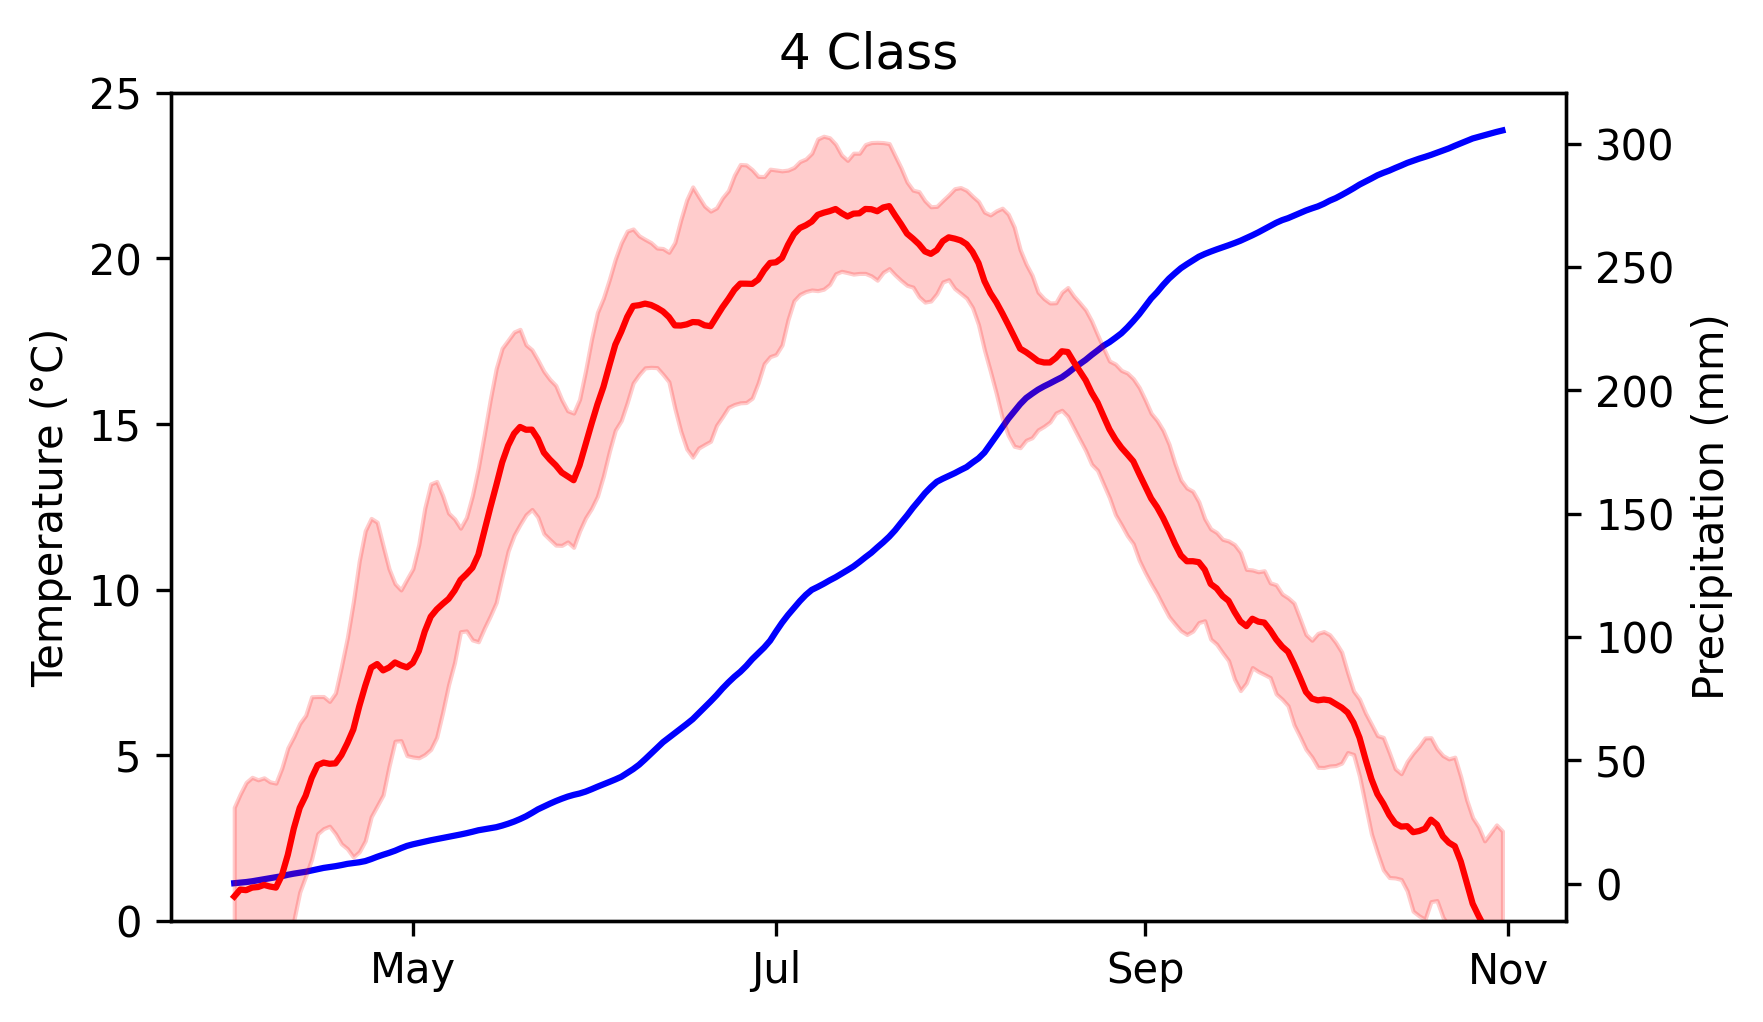

In [29]:
date_df = min_temp[['Month', 'Day']]
date_df['Year'] = [2000 for _ in range(len(date_df))]
x = pd.to_datetime(date_df)[91:-61]

mean_temps = []
mean_precs = []

for i in range(4):
    mean_temp = get_moving_avg(min_temp)[[year for year in a_classified[a_classified['Class 4']==i]['Year'] if year in min_temp.columns]]
    y = mean_temp.mean(axis=1)[91:-61]
    mean_temps += [y]
    dy = mean_temp.std(axis=1)[91:-61]

    fig, ax = plt.subplots(nrows=1, ncols=1, dpi=300, figsize=(6, 3))
    plt.subplots_adjust(bottom=0.03, top=0.95)

    ax.fill_between(x, y-dy, y+dy, color='red', alpha=0.2)
    ax.plot(x, y, c='red')

    mean_prec = get_moving_avg(min_prec)[[year for year in a_classified[a_classified['Class 4']==i]['Year'] if year in min_prec.columns]]
    y = mean_prec.mean(axis=1)[91:-61]
    mean_precs += [list_to_cumulative(y)]
    dy = mean_prec.std(axis=1)[91:-61]
    
    ax2 = ax.twinx()
    #ax2.fill_between(x, [0 for _ in y], list_to_cumulative(y), color='blue', alpha=0.1)
    ax2.plot(x, np.array(list_to_cumulative(y)), color='blue')
    #ax2.set_ylim([0, 350])
    
    ax.set_ylabel('Temperature (°C)')
    ax2.set_ylabel('Precipitation (mm)')
    ax.set_zorder(1)  # default zorder is 0 for ax1 and ax2
    ax.patch.set_visible(False)  # prevents ax1 from hiding ax2

    locator = mdates.AutoDateLocator(minticks=3, maxticks=7)
    formatter = mdates.ConciseDateFormatter(locator)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)
    #ax.set_xlim([date(2000, 4, 1), date(2000, 10, 30)])
    ax.set_ylim([0, 25])

    selected = a_classified[a_classified['Class 4']==i]
    temp_to_plot = monthly_temp.loc[monthly_temp['Year'].isin(list(selected['Year']))]
    

    ax.set_title(f'{i+1} Class')
    #plt.savefig(f'../output/{i+1} Class (d&cwt)', dpi=300)
    
    plt.show()
    plt.close(fig)

In [44]:
temp_max = max([max(el) for el in mean_temps])
prec_max = max([max(el) for el in mean_precs])
temp_min = min([min(el) for el in mean_temps])
prec_min = min([min(el) for el in mean_precs])

In [45]:
scaled_mean_temps = [(np.array(el) - temp_min) / (temp_max - temp_min) for el in mean_temps]
scaled_mean_precs =  [(np.array(el) - prec_min) / (prec_max - prec_min) for el in mean_precs]

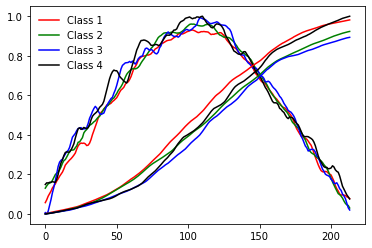

In [100]:
colors = ['red', 'green', 'blue', 'black']
i = 0
for el in scaled_mean_temps:
    plt.plot(el, color =colors[i], label=f'Class {i+1}')
    i += 1
i = 0
for el in scaled_mean_precs:
    plt.plot(el, color =colors[i])
    i += 1
plt.legend(frameon=False)
plt.show()

In [96]:
i = 1
for temp, prec in zip(scaled_mean_temps, scaled_mean_precs):
    print('Class', i, ':', trapz(temp) - trapz(prec))
    i += 1

Class 1 : 19.0702795845408
Class 2 : 32.62399443558536
Class 3 : 40.22224592408021
Class 4 : 34.02859517227718


In [72]:
temp_df = get_moving_avg(min_temp)[91:-61].reset_index(drop=True)

scaled_temp_df = (temp_df - min(temp_df.min()[2:])) / (max(temp_df.max()[2:]) - min(temp_df.min()[2:]))
scaled_temp_df['Month'] = temp_df['Month']
scaled_temp_df['Day'] = temp_df['Day']

In [82]:
cum_prec = {
    'Month': list(min_prec['Month']),
    'Day': list(min_prec['Day'])
}
for column in min_prec.columns:
    if column in ['Day', 'Month']:
        continue
    cum_prec[column] = list_to_cumulative(min_prec[column])
cum_prec = pd.DataFrame(cum_prec)

In [87]:
prec_df = get_moving_avg(cum_prec)[91:-61].reset_index(drop=True)
scaled_prec_df = (prec_df - min(prec_df.min()[2:])) / (max(prec_df.max()[2:]) - min(prec_df.min()[2:]))
scaled_prec_df['Month'] = prec_df['Month']
scaled_prec_df['Day'] = prec_df['Day']

In [90]:
areas = []

for column in scaled_prec_df.columns:
    if column in ['Day', 'Month']:
        continue
    areas += [trapz(scaled_temp_df[column]) - trapz(scaled_prec_df[column])]

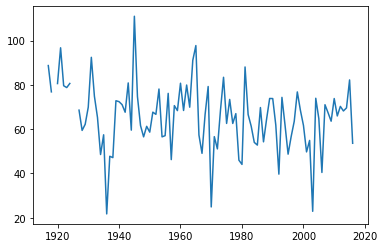

In [93]:
plt.plot(scaled_prec_df.columns[2:], areas)

In [98]:
pd.DataFrame({'Year': scaled_prec_df.columns[2:], 'Area':areas}).to_csv('../output/Year_Areas_difference.csv', index=False)